# Calculate the spectrum of twisted bilayer graphene in a pathway (typically through high-symmetry points)

In [3]:
#************************** Import packages **************************#

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import timeit
import kwant
from numpy import sin, exp, cos, pi, sqrt
import scipy.sparse.linalg as sla
import copy
import datetime
from shapely.geometry import Point, Polygon
from scipy import linalg
from scipy.optimize import linear_sum_assignment

#************************** Define constant variables  **************************#

sin_30, cos_30 = (1. / 2, sqrt(3.) / 2) 
a0 = 2.46 # Honeycomb lattice constant (not nearest-neighbors!) [A]
d0 = 3.35 # Distance between the layers [A]
lcon = a0 / sqrt(3) # Nearest neighbor constant [A]
Vppp = 3.09 # Nearest-neighbor intralayer hopping amplitude of graphene [eV]
            # The most common values in the literature are (2.7, 3.09) [eV]
Vpps = 0.390  # Nearest-neighbor interlayer hopping amplitude of bilayer graphene[eV]
              # The most common values in the literature are (0.48, 0.39) [eV]
chem_pot = 0. # Chemical potential in the scatterer [eV]
lambda0 = 0.27 # Constant that determines the exponential rate of decay of the interlayer hoppings[A]



C:\ProgramData\Miniconda3\lib\site-packages\kwant\solvers\default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


## First step: Generating the lattice

In [4]:
#************************** Define a few helpful functions **************************#

def parallelogram(v1, v2, trans = np.array([0,0]), return_coords = False):
    
    """ Create a parallelogram.
    
    Parameters:
    -----------
    v1, v2: Numpy arrays
        sides of the parallelogram
    trans: NumPy array
        position of the bottom left corner of the parallelogram
    return_coords: Bool
        if set to True the coordinates of the parallelogram are the second output
        
    Returns:
    --------
    poly: Shapely polygon
        Polygon of the parallelogram
    coords: NumPy array
        Optional output, coordinates of the vertices of the parallelogram
    """
    
    coords = np.array([trans, v1 + trans, v1 + v2 + trans, v2 + trans, trans])
    poly = Polygon(coords[:4])
    
    if return_coords:
        coords_new = [[],[]]
        for i in range(len(coords)):
            coords_new[0].append(coords[i][0])
            coords_new[1].append(coords[i][1])
        return poly, coords_new
    else:
        return poly
    
        
def rotate(v, theta):

    '''
        Rotate a vector in 3D ( NumPy array or list) by an angle theta (in radians) along the z-axis
    '''
    

    Rmatrix = np.array([[cos(theta), -sin(theta), 0.],
                        [sin(theta),  cos(theta), 0.],
                        [0.        ,          0., 1.]])
    
    return Rmatrix @ v


def plot_layer(layer_sites, mUC_coords = []):
    
    """ Plot a single layer of graphene.
    
    Parameters:
    -----------
    layer_sites: List
        Kwant sites that make one unit cell of the crystal
    mUC_coords: List
        coordinates of the unit cell in reciprocal space
        
    Returns: None

    """

    xs = []
    ys = []
    
    for i in range(len(layer_sites)):
        xs.append(layer_sites[i].pos[0])
        ys.append(layer_sites[i].pos[1])
    
    plt.figure(figsize=(10,10))
    plt.scatter(xs,ys,s=10,c='k')
    
    if len(mUC_coords) > 0:
        plt.plot(mUC_coords[0], mUC_coords[1],c='r') 
        
    boundary = max(max(xs), max(ys))
        
    plt.xlim(-5,1.2 * boundary + 1)
    plt.ylim(-5,1.2 * boundary + 1) 
    plt.show()
    plt.close()
    
#************************************************ Main function ************************************************#

def create_lattice(theta = 7.34, stacking = 'AA', plot_layers = True, timer = True): 
    
    '''
        Generate two lists of kwant site objects containing the nodes in one moire Unit Cell (mUC). 
            - Use plot_layers for visual confimation that the lattice is fully periodic (for commensurate angles)
            - The stacking should be AA or AB (no error raised if it is otherwise, it will default to AA)
        
    '''
    
    """ Generate the list of sites of one moire unit cell.
    
    Parameters:
    -----------
    theta: float
        twist angle in degrees
    stacking: 'AA' or 'AB'
        stacking of bilayer graphene at zero twisting
    plot_layers: bool
    timer: bool
        
    Returns:
    --------
    bot_sites, top_sites: lists

    """
    
    start = timeit.default_timer()
    theta = np.radians(theta)
    global Lm, V1, V2 # These costants are necessary in outer functions, so I made them global.
    
    # Creating the two lattices for the layers
    
    Lm = a0 / (2 * sin(theta / 2)) # Honeycomb lattice constant of mUC [A]
    V1 = Lm * np.array([cos_30, sin_30, 0]) # Primitive vectors of mUC [A]
    V2 = Lm * np.array([0,1, 0 ])
    
    a1 = a0 * np.array([sin_30,cos_30,0]) # Primitive vectors of unrotated graphene
    a2 = a0 * np.array([1,0,0])

    a1_top = rotate(a1,theta / 2) # Primitive vectors top layer
    a2_top = rotate(a2,theta / 2)

    a1_bot = rotate(a1,-theta / 2) # Primitive vectors bottom layer    
    a2_bot = rotate(a2,-theta / 2)

    basis_top1 = np.array([0,0,d0]) # Basis vectors top layer
    basis_top2 = rotate(np.array( [0, lcon,d0]),theta / 2)

    if stacking == 'AB':
        basis_top1 += np.array([lcon*sin_30,lcon*cos_30,0])
        basis_top2 += np.array([lcon*sin_30,lcon*cos_30,0])
        
    basis_bot1 = np.array([0,0,0]) # Basis vectors bottom layer
    basis_bot2 = rotate(np.array( [0, lcon,0]), -theta / 2)

    top_layer = kwant.lattice.general([a1_top, a2_top],
                                     [basis_top1, basis_top2],
                                     norbs=1)

    bot_layer = kwant.lattice.general([a1_bot, a2_bot],
                                     [basis_bot1, basis_bot2],
                                     norbs=1)

    ab, bb = bot_layer.sublattices
    at, bt = top_layer.sublattices

    syst = kwant.Builder()
    
    # Create the moire unit cell
    poly, coords = parallelogram(V1[0:2],V2[0:2],trans = np.array([0,0]), return_coords = True)
    
    eps = 0.2 
    def is_inside_polygon(pos): # We include all sides inside or at a small distance of the mUC, latter we will delete repeated sites
        x,y,z = pos
        pt = Point([x,y])
        return pt.within(poly) or pt.distance(poly) < eps
    
    # Adding all sites inside the mUC

    syst[bot_layer.shape(is_inside_polygon, (ab(3,0).pos[0], ab(3,0).pos[1], 0))] = 0
    bot_sites = list(syst.sites())

    syst[top_layer.shape(is_inside_polygon, (at(3,0).pos[0], at(3,0).pos[1], 0))] = 0
    top_sites = list(syst.sites())[len(bot_sites):] 
    
    # Making polygons at the boundaries (for the hoppings between the unit cells)
    
    poly_left = parallelogram(V1[0:2] * 5 / Lm,V2[0:2],trans = np.array([0,0]))
    poly_right = parallelogram(V1[0:2] * 5 / Lm,V2[0:2],trans = V1[0:2] * (1 - 5 / Lm))
    poly_bot = parallelogram( V1[0:2] , V2[0:2] * 5 / Lm,trans = np.array([0,0]))
    poly_top = parallelogram( V1[0:2] , V2[0:2] * 5 / Lm,trans = V2[0:2] * (1 - 5 / Lm))

    bot_sites_left, bot_sites_right, bot_sites_bot, bot_sites_top = [],[],[],[]
    top_sites_left, top_sites_right, top_sites_bot, top_sites_top = [],[],[],[]
    
    # Adding the sites in the boundary polygons
    
    for i,site in enumerate(bot_sites):
        x,y,z = site.pos
        pt = Point([x,y])
        if pt.within(poly_left) or pt.distance(poly_left) < eps:
            bot_sites_left.append(site)
        if pt.within(poly_right) or pt.distance(poly_right) < eps:
            bot_sites_right.append(site)
        if pt.within(poly_bot) or pt.distance(poly_bot) < eps:
            bot_sites_bot.append(site)
        if pt.within(poly_top) or pt.distance(poly_top) < eps:
            bot_sites_top.append(site)
            
    for i,site in enumerate(top_sites):
        x,y,z = site.pos
        pt = Point([x,y])
        if pt.within(poly_left) or pt.distance(poly_left) < eps:
            top_sites_left.append(site)
        if pt.within(poly_right) or pt.distance(poly_right) < eps:
            top_sites_right.append(site)
        if pt.within(poly_bot) or pt.distance(poly_bot) < eps:
            top_sites_bot.append(site)
        if pt.within(poly_top) or pt.distance(poly_top) < eps:
            top_sites_top.append(site)
            
    def distance_arrays(pos1, pos2):
        '''
            Calculate the distance between two NumPy arrays in 3D
        '''
        x1,y1,z1 = pos1
        x2,y2,z2 = pos2
        sq = (x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2
        return sqrt(sq)
    
    # Eliminating stacked sites
    
    for translated_bot_sites in [bot_sites_left, bot_sites_bot]:
        for non_translated_bot_sites in [bot_sites_right, bot_sites_top]:
            for site1 in non_translated_bot_sites:
                for site2 in translated_bot_sites:
                    for translation in [V1, V2, V1 + V2, V1 - V2]:
                        dist = distance_arrays(site1.pos, site2.pos + translation)
                        if dist < 0.1:
                            try: 
                                bot_sites.remove(site1)
                            except: # If twice stacked this would raise an error, as it deleted the site already
                                None 
                                
    for translated_top_sites in [top_sites_left, top_sites_bot]:
        for non_translated_top_sites in [top_sites_right, top_sites_top]:
            for site1 in non_translated_top_sites:
                for site2 in translated_top_sites:
                    for translation in [V1, V2, V1 + V2, V1 - V2]:
                        dist = distance_arrays(site1.pos, site2.pos + translation)
                        if dist < 0.1:
                            try: 
                                top_sites.remove(site1)
                            except: # If twice stacked this would raise an error, as it deleted the site already
                                None 

    # Plotting
    
    if plot_layers:
        
        plot_layer(bot_sites, mUC_coords = coords)
        plot_layer(top_sites, mUC_coords = coords)
    
    # Printing out timer
    
    if timer:
        
        print('Creating the lattice took: {:.2f}s'.format(timeit.default_timer() - start))
               
    return bot_sites, top_sites


## Second step: Extracting the Hamiltonian of the infinite system (unit cell with periodic boundary conditions)

In [5]:
#***************************************** Helpful secondary functions *****************************************#

def quick_plot(syst): # Makes a quick plot of a kwant.Builder object    
    
    '''
        Show a quick plot of a kwant system (Kwant.Builder) object
    '''
    
    azim, dist, elev = -90, 10, 90 # Default: -60, 10, 30, View from above: -90, 10, 90
    fig = plt.figure(figsize=(15,15))
    ax = fig.gca(projection='3d')
    ax.azim = azim
    ax.dist = dist
    ax.elev = elev             
        
    def site_color(site):
        '''
            Set the color of the nodes (black or white in the graphene sublattices)
        '''
        x,y,z = site.pos
        if z > 0.1:
            return 'black'
        else:
            return 'white'
        
    kwant.plot(syst,site_size = 0.25 ,site_color = site_color,hop_lw = 0.1,ax = ax, num_lead_cells = 4);
    plt.show()
    plt.close()
    
def distance_sites(site1, site2):
    
    '''
        Calculate the distance between two kwant site objects
    '''
    
    x1,y1,z1 = site1.pos
    x2,y2,z2 = site2.pos
    sq = (x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2
    
    return sqrt(sq)
    
def interlayer_hopping(dist): 
    
    '''
        Returns the interlayer hopping given the distanc between using the minimal model (exponential decay)
    '''
    
    ex = exp( - ( dist - d0 ) / lambda0)
    
    return Vpps * ex * d0 * d0 / (dist ** 2)

def get_commesurate_angles(N = 1, return_angles = False):
    
    '''
        Prints or returns N commensurate angles 
    '''
    
    angles = []
    q = 1
    for p in range(N):
        p += 1
        num = 3*p*p + 3*p*q + q*q/2
        denom = 3*p*p + 3*p*q + q*q
        angles.append(np.degrees(np.arccos(num / denom)))
        
    if return_angles:
        return angles
        
    print(angles)
            

#************************************************ Main function ************************************************#

def generate_hamiltonian(bot_sites, top_sites, Nx = 1, Ny = 1, cutoff = 5, timer = True):
    
    '''
        Returns a function that generates the sparse matrix for a given pseudomomentum (kx, ky). It takes the list of sites in the
        top and bottom layers.
            - Nx and Ny are the number of subcells to be generated (to drastically reduce the number of interlayer hoppings). Testing showed
              that Nx(Ny) approx Lm / 5 is a good choice.
            - cutoff determines the distance at which the subcells will have interlayer hoppings between them: 5 is very good 
              though it can be lowered and it still reproduces the results with negligible error.
    '''
    
    start = timeit.default_timer()
    bot_pos = [bot_sites[i].pos for i in range(len(bot_sites))]
    top_pos = [top_sites[i].pos for i in range(len(top_sites))]
    
    bot_lat = kwant.lattice.general([V1,V2], bot_pos)
    top_lat = kwant.lattice.general([V1,V2], top_pos)
    
    bot_sublats = bot_lat.sublattices
    top_sublats = top_lat.sublattices
    syst = kwant.Builder(kwant.TranslationalSymmetry(V1,V2))
    
    for i in range(len(bot_pos)):
        syst[bot_sublats[i](0,0)] = -chem_pot
        
    for i in range(len(top_pos)):
        syst[top_sublats[i](0,0)] = -chem_pot

    V1p = V1[0:2] / Nx
    V2p = V2[0:2] / Ny
    
    polygons = []
    site_domains_bot = []
    site_domains_top = []
    sites = list(syst.sites())
    
    for nx in range(Nx):
        vector_polygon_temp = []
        site_domain_bot = []
        site_domain_top = []
        for ny in range(Ny):
            sites_bot_temp = []
            sites_top_temp = []
            trans_temp =  V1p * nx + V2p * ny - (cutoff / 2) * np.array([cos_30, sin_30 + 1])
            poly_temp, coords = parallelogram(V1p + cutoff * np.array([cos_30, sin_30]),\
                                              V2p + cutoff * np.array([0,1]) ,\
                                              trans = trans_temp, return_coords = True)
            vector_polygon_temp.append(poly_temp)
            for site in sites:
                x,y,z = site.pos
                pt = Point([x,y])
                if pt.within(poly_temp):
                    if z == 0:
                        sites_bot_temp.append(site)
                    else:
                        sites_top_temp.append(site)

            site_domain_bot.append(sites_bot_temp)
            site_domain_top.append(sites_top_temp)
    
        polygons.append(vector_polygon_temp)
        site_domains_bot.append(site_domain_bot)
        site_domains_top.append(site_domain_top)
    
    if timer:
        print('Creating the system and dividing it into subdomains took {:.2f}s'.format(timeit.default_timer() - start))
    
    start = timeit.default_timer()
        
    # Intralayer hoppings within the unit cell

    for nx in range(Nx):
        for ny in range(Ny):
            for site1 in site_domains_bot[nx][ny]:
                for site2 in site_domains_bot[nx][ny]:
                    dist = distance_sites(site1,site2)
                    if np.isclose(lcon, dist,atol=0.001):
                        syst[site1, site2] = -Vppp
            for site1 in site_domains_top[nx][ny]:
                for site2 in site_domains_top[nx][ny]:
                    dist = distance_sites(site1,site2)
                    if np.isclose(lcon, dist,atol=0.001):
                        syst[site1, site2] = -Vppp
                        
                        
    # Intralayer hoppins at the boundaries
    
    for nx in range(Nx):
        for site_domains in [site_domains_bot, site_domains_top]:
            for site1 in site_domains[nx][0]:
                for site2 in site_domains[nx][Ny-1]:
                    site1_sublat = site1.family
                    site2_sublat = site2.family
                    dist = distance_sites(site1_sublat(0,0), site2_sublat(0,-1))
                    if np.isclose(lcon, dist,atol=0.01):
                        syst[kwant.builder.HoppingKind((0,-1), site2_sublat, site1_sublat)] = - Vppp

                
    for ny in range(Ny):
        for site_domains in [site_domains_bot, site_domains_top]:
            for site1 in site_domains[0][ny]:
                for site2 in site_domains[Nx-1][ny]:
                    site1_sublat = site1.family
                    site2_sublat = site2.family
                    dist = distance_sites(site1_sublat(0,0), site2_sublat(-1,0))
                    if np.isclose(lcon, dist,atol=0.01):
                        syst[kwant.builder.HoppingKind((-1,0), site2_sublat, site1_sublat)] = - Vppp
                        
    if timer:
        print('Adding the intralayer hoppings took {:.2f}s'.format(timeit.default_timer() - start))
        
    start = timeit.default_timer()
        
    # Interlayer hoppings within the unit cell
    
    for nx in range(Nx):
        for ny in range(Ny):
            for site1 in site_domains_bot[nx][ny]:
                for site2 in site_domains_top[nx][ny]:
                    dist = distance_sites(site1,site2)
                    syst[site1,site2] = -interlayer_hopping(dist)
                    
    #Interlayer hoppings at the boundaries
                    
    for nx in range(Nx):
        for site1 in site_domains_bot[nx][0]:
            for site2 in site_domains_top[nx][Ny-1]:
                site1_sublat = site1.family
                site2_sublat = site2.family
                dist = distance_sites(site1_sublat(0,0), site2_sublat(0,-1))
                syst[kwant.builder.HoppingKind((0,-1), site2_sublat, site1_sublat)] = - interlayer_hopping(dist)
        for site1 in site_domains_top[nx][0]:
            for site2 in site_domains_bot[nx][Ny-1]:
                site1_sublat = site1.family
                site2_sublat = site2.family
                dist = distance_sites(site1_sublat(0,0), site2_sublat(0,-1))
                syst[kwant.builder.HoppingKind((0,-1), site2_sublat, site1_sublat)] = - interlayer_hopping(dist)
                
    for ny in range(Ny):
        for site1 in site_domains_bot[0][ny]:
            for site2 in site_domains_top[Nx-1][ny]:
                site1_sublat = site1.family
                site2_sublat = site2.family
                dist = distance_sites(site1_sublat(0,0), site2_sublat(-1,0))
                syst[kwant.builder.HoppingKind((-1,0), site2_sublat, site1_sublat)] = - interlayer_hopping(dist)
        for site1 in site_domains_top[0][ny]:
            for site2 in site_domains_bot[Nx-1][ny]:
                site1_sublat = site1.family
                site2_sublat = site2.family
                dist = distance_sites(site1_sublat(0,0), site2_sublat(-1,0))
                syst[kwant.builder.HoppingKind((-1,0), site2_sublat, site1_sublat)] = - interlayer_hopping(dist)
                
    for site1 in site_domains_bot[0][0]:
        for site2 in site_domains_top[Nx-1][Ny-1]:
            site1_sublat = site1.family
            site2_sublat = site2.family
            dist = distance_sites(site1_sublat(0,0), site2_sublat(-1,-1))
            syst[kwant.builder.HoppingKind((-1,-1), site2_sublat, site1_sublat)] = - interlayer_hopping(dist)
            
    for site1 in site_domains_top[0][0]:
        for site2 in site_domains_bot[Nx-1][Ny-1]:
            site1_sublat = site1.family
            site2_sublat = site2.family
            dist = distance_sites(site1_sublat(0,0), site2_sublat(-1,-1))
            syst[kwant.builder.HoppingKind((-1,-1), site2_sublat, site1_sublat)] = - interlayer_hopping(dist)
            
    for site1 in site_domains_bot[Nx-1][0]:
        for site2 in site_domains_top[0][Ny-1]:
            site1_sublat = site1.family
            site2_sublat = site2.family
            dist = distance_sites(site1_sublat(0,0), site2_sublat(1,-1))
            syst[kwant.builder.HoppingKind((1,-1), site2_sublat, site1_sublat)] = - interlayer_hopping(dist)
            
    for site1 in site_domains_top[Nx-1][0]:
        for site2 in site_domains_bot[0][Ny-1]:
            site1_sublat = site1.family
            site2_sublat = site2.family
            dist = distance_sites(site1_sublat(0,0), site2_sublat(1,-1))
            syst[kwant.builder.HoppingKind((1,-1), site2_sublat, site1_sublat)] = - interlayer_hopping(dist)
        
    if timer:
        print('Adding the interlayer hoppings took {:.2f}s'.format(timeit.default_timer() - start))
    
    start = timeit.default_timer()
    
    syst_wrap = kwant.wraparound.wraparound(syst,coordinate_names=('x','y'))
    systf = syst_wrap.finalized()
    Ham = lambda kx,ky: systf.hamiltonian_submatrix(params=dict(k_x=kx,k_y=ky), sparse = True)

    if timer:
        print('Wrapping up the system took {:.2f}s'.format(timeit.default_timer() - start))
    
    return Ham

## Step three: Define the path of integration in the moire Brillouin Zone

In [6]:
def get_standard_path_coords():
    
    '''
        Returns a list with the coordinates of the standard pathway through the mBZ (K_D -> Gamma -> M -> K_D')
    '''
    
    k_D = 2 * np.pi / np.sqrt(3)
    Gamma = np.array([0,0])
    K_D = k_D * np.array([cos_30,sin_30])
    K_Dp = k_D * np.array([cos_30,-sin_30])
    M = k_D * np.array([cos_30,0])
    
    coords = [K_D, Gamma, M, K_Dp]
    
    return coords


def get_path(path_coords, ds = 0.1, show_path = True, convert_pseudomomenta = True):
    
    '''
        Returns three NumPy arrays: the x-components of the pseudomomenta (kxs), the y-components (kys) and the pathway length (path_length)
            - convert_pseudomomenta rotates the components so that they can be given as input to the hamiltonian function. In kwant the pseudomomenta
              are not automatically expressed in a orthogonal basis (so without conversion it really shouldn't be understood as kxs and kys).
            - ds determines the precision, it is the length of each jump.
    '''
    
    kxs, kys = [path_coords[0][0]], [path_coords[0][1]]
    path_length = [0]
    pointer = path_coords[0]
    
    for i in range(len(path_coords[1:])):
        
        translation = path_coords[i+1] - path_coords[i]
        N = int(np.sqrt(np.dot(translation,translation)) / ds)
        
        for n in range(N):
            pointer += translation / N
            kxs.append(pointer[0])
            kys.append(pointer[1])
            path_length.append(ds + path_length[-1])
            
    kxs, kys, path_length = np.array(kxs), np.array(kys), np.array(path_length)
    
    if show_path:

        k_D = 2 * np.pi / np.sqrt(3)
        Gamma = np.array([0,0])
        K_D = k_D * np.array([cos_30,sin_30])
        K_Dp = k_D * np.array([cos_30,-sin_30])
        M = k_D * np.array([cos_30,0])
        mBZ_coordinates = [K_D, K_Dp, np.array([0,-k_D]), -K_D, -K_Dp, np.array([0,k_D]), K_D]
        
        plt.figure(figsize = (6,6))
        plt.scatter(kxs,kys);   
        plt.xlim(-k_D * 1.1,k_D * 1.1)
        plt.ylim(-k_D * 1.1,k_D * 1.1)

        
        for i in range(len(mBZ_coordinates) - 1):    
            plt.plot([mBZ_coordinates[i][0],mBZ_coordinates[i+1][0]],[mBZ_coordinates[i][1],mBZ_coordinates[i+1][1]],'r--')
            
    if convert_pseudomomenta:
        
        kxs = kxs + (kys * sin_30 / cos_30)
        kys = kys / cos_30

    return kxs, kys, path_length

#path_coords = get_standard_path_coords()
#kxs, kys, path_length = get_path(path_coords, ds = 0.04, show_path=False)

## Step four: Diagonalize the Hamiltonian through the integration path

In [7]:
def estimate_diagonalization_time(Ham, path_length, Nen = 16, sigma = 0, tol = 1e-4, return_eigenvectors = False):
    
    '''
        Diagonalizes the Hamiltonian in one point and estimates the total runtime
    '''
    
    N = len(path_length)
        
    start = timeit.default_timer()
    
    sla.eigsh(Ham(0,0), k = Nen, sigma=sigma, return_eigenvectors=return_eigenvectors, which='LM',tol=tol)
    
    time = timeit.default_timer() - start
    time1 = str(datetime.timedelta(seconds = time))
    time2 = str(datetime.timedelta(seconds = time * N))
    
    print('Diagonalizing one matrix takes: {}; estimated runtime: {}'.format(time1, time2))
    
def diagonalize_matrices(Ham, kxs, kys, Nen = 16, sigma = 0, tol =1e-5, return_eigvecs = False, timer = True):
    
    '''
        Diagonalize the Hamiltonian through the line in the mBZ indicated with NumPy Arrays kxs, kys (already converted!)
    '''
    
    start = timeit.default_timer()
    N = len(path_length)
    energies = []
    
    if return_eigvecs:
        eigvecs = []
        
        for i in range(N):
            en_temp, eigvec_temp = sla.eigsh(Ham(kxs[i],kys[i]), k=Nen, sigma=sigma, return_eigenvectors = True, 
                                             which='LM',tol=tol)
            energies.append(np.sort(en_temp))
            eigvecs.append(eigvec_temp)
            
            
    else:
        for i in range(N):
            energies[i,:] = np.sort(sla.eigsh(Ham(kxs[i],kys[i]), k=Nen, sigma=sigma, return_eigenvectors = False, 
                                              which='LM',tol=tol))

    if timer:
        print('Diagonalizing the matrices took: {}'.format(str(datetime.timedelta(seconds = int(timeit.default_timer() - start)))))
        
    return [energies, eigvecs] if return_eigvecs else energies


# Plotting 

In [8]:
def plot_spectrum(path_length, energies, ylim = (-0.1,0.1), figsize = (12,8), save_file = False):
    
    '''
        Plot the spectrum through high-symmetry lines
    '''
    energies = np.array(energies)
    k_D = 2 * np.pi / np.sqrt(3)
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=figsize)
    plt.title("Theta = {:.2f}   Interlayer hopping = {:.3f}".format(theta,Vpps))
    Nen = len(energies[0,:])
    
    for i in range(Nen):
        plt.scatter(path_length,energies[:,i], color = 'k')
        
    plt.plot((0,0),(-13,13),'r--',lw = 0.5)
    plt.plot((k_D,k_D),(-13,13),'r--',lw = 0.5)
    plt.plot((k_D*(1+cos_30),k_D*(1+cos_30)),(-13,13),'r--',lw = 0.5)
    plt.plot((k_D*(1+cos_30+sin_30),k_D*(1+cos_30+sin_30)),(-13,13),'r--',lw = 0.5)
    
    plt.ylim(ylim)
    plt.ylabel("Energy[eV]")
    plt.grid(False)
    
    plt.xticks([0,k_D,k_D*(1+cos_30),k_D*(1+cos_30+sin_30)], ['K','$\Gamma$','M','K\''])
    
    if save_file == True:
        plt.savefig("Spectrum TBG_theta={:.2f}_Vpps={:.3f}.png".format(theta, Vpps))
        
    plt.show()
    plt.close()

In [15]:
def get_commensurate_angles(q = 1, N = 1, print_angles = True):
    '''
        Returns N commensurate angles (in degrees) of TBG, from highest to lowest                         
    '''
    
    angles = []
    for p in range(N):
        p += 1
        num = 3*p*p + 3*p*q + q*q/2
        denom = 3*p*p + 3*p*q + q*q
        angles.append(np.degrees(np.arccos(num / denom)))
    if print_angles:
        for angle in angles:
            print(angle, end = ', ')
    return(angles)

# angles = get_commensurate_angles(N = 50, print_angles = True)


21.78678929826181, 13.173551107258918, 9.430007907896421, 7.340993016630217, 6.008983197766148, 5.085847808123473, 4.408455007944072, 3.8902381690076835, 3.481006089466939, 3.149657426389616, 2.875894633632971, 2.6459083811926885, 2.4499772766168695, 2.2810596097298803, 2.1339296665972505, 2.004627830691014, 1.8900990734694358, 1.787948610382325, 1.6962726935197672, 1.6135389011625705, 1.538499818371707, 1.4701297257779093, 1.4075774463457396, 1.350130735571569, 1.2971890475935015, 1.2482424655263473, 1.202855227481003, 1.1606527198522039, 1.1213111153817366, 1.0845490491576433, 1.0501208797943464, 1.0178111944464099, 0.9874302978136178, 0.9588104855247125, 0.9318029472641524, 0.9062751788952574, 0.8821088085785386, 0.8591977616312254, 0.8374467041002995, 0.8167697168934015, 0.7970891615735539, 0.7783347062604242, 0.7604424858747353, 0.7433543755966325, 0.7270173601214672, 0.7113829842947408, 0.6964068731333408, 0.6820483112208993, 0.6682698730820834, 0.6550370974653603, 

# Example

Twist angle: 1.787948610382325
Creating the lattice took: 2.22s
Creating the system and dividing it into subdomains took 15.44s
Adding the intralayer hoppings took 8.89s
Adding the interlayer hoppings took 23.41s
Wrapping up the system took 4.53s
Diagonalizing one matrix takes: 0:00:02.869123; estimated runtime: 0:08:10.619965
Diagonalizing the matrices took: 0:07:34


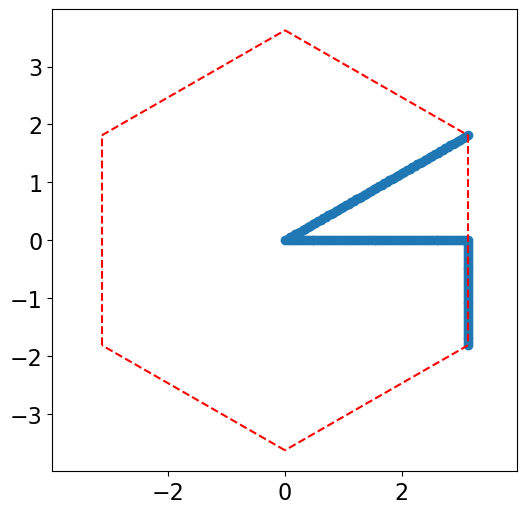

In [20]:
#************************************** Getting a commensurate twist angle **************************************#
Vpps = 0.390
theta = 1.787948610382325
print('Twist angle: ' + str(theta))

#*************************************** Generating the trajectory points ***************************************#

path_coords = get_standard_path_coords()
kxs, kys, path_length = get_path(path_coords, ds = 0.05, show_path=True)


#*********************************** Obtaining the lists of sites in the mBZ ***********************************#

bot_sites, top_sites = create_lattice(theta = theta, plot_layers = False)

#****************************************** Generating the Hamiltonian ******************************************#

Ham = generate_hamiltonian(bot_sites, top_sites, Nx = int(Lm/5), Ny = int(Lm/5), cutoff = 4)

#************************************** Diagonalizing the sparse matrices **************************************#

estimate_diagonalization_time(Ham, path_length=path_length, return_eigenvectors=True)
energies, eigvecs = diagonalize_matrices(Ham, kxs, kys, Nen = 16, sigma = 0, tol =1e-4, return_eigvecs = True, timer = True)


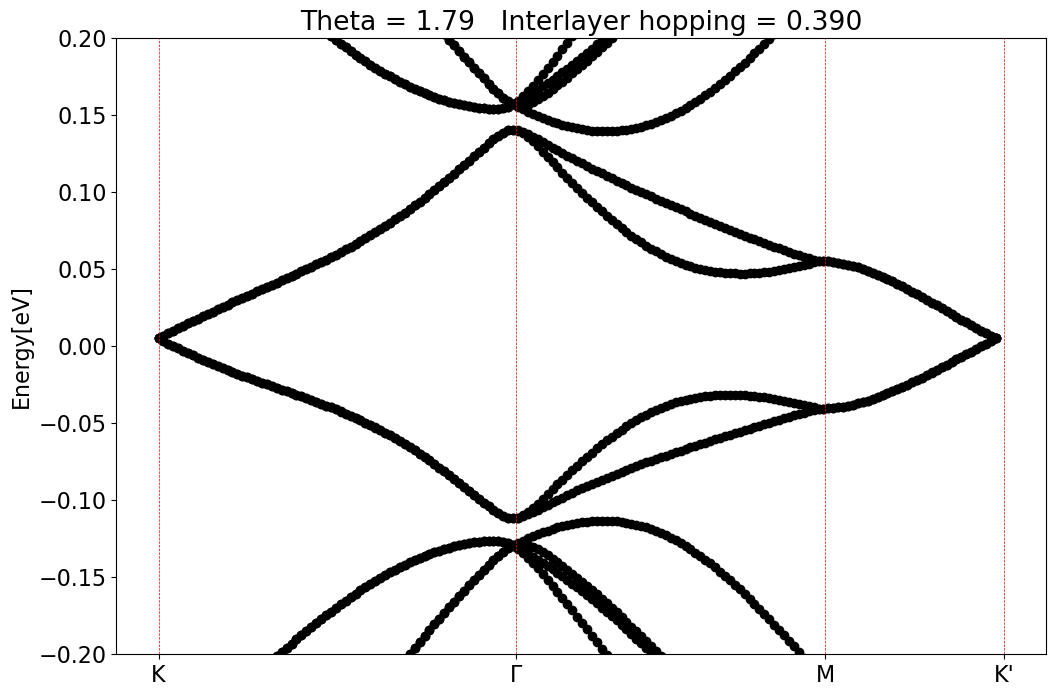

In [22]:
#*************************************************** Plotting ***************************************************#

plot_spectrum(path_length, energies, ylim = (-0.2,0.2), figsize = (12,8), save_file = False)

In [32]:
#********************************************* Connecting the dots *********************************************#
#******************* Taken from https://quantumtinkerer.tudelft.nl/blog/connecting-the-dots/ *******************#

def best_match(psi1, psi2, threshold=None):
    """Find the best match of two sets of eigenvectors.

    
    Parameters:
    -----------
    psi1, psi2 : numpy 2D complex arrays
        Arrays of initial and final eigenvectors.
    threshold : float, optional
        Minimal overlap when the eigenvectors are considered belonging to the same band.
        The default value is :math:`1/(2N)^{1/4}`, where :math:`N` is the length of each eigenvector.
    
    Returns:
    --------
    sorting : numpy 1D integer array
        Permutation to apply to ``psi2`` to make the optimal match.
    diconnects : numpy 1D bool array
        The levels with overlap below the ``threshold`` that should be considered disconnected.
    """
    if threshold is None:
        threshold = (2 * psi1.shape[0])**-0.25
    Q = np.abs(psi1.T.conj() @ psi2)  # Overlap matrix
    orig, perm = linear_sum_assignment(-Q)
    return perm, Q[orig, perm] < threshold


e, psi = energies[0], eigvecs[0]
sorted_levels = [e]
for i in range(len(energies[1:])):
    e2, psi2 = energies[i + 1], eigvecs[i + 1]
    perm, line_breaks = best_match(psi, psi2, threshold=None)
    e2 = e2[perm]
    intermediate = (e + e2) / 2
    intermediate[line_breaks] = None
    psi = psi2[:, perm]
    e = e2
    
    sorted_levels.append(intermediate)
    sorted_levels.append(e)

# plt.plot(sorted_levels, color = 'k');

In [31]:
def plot_continuous_spectrum(sorted_levels, ylim = (-0.1,0.1), figsize = (12,8), save_file = False):
    
    '''
        Plot the spectrum through high-symmetry lines
    '''
    energies = np.array(sorted_levels)
    
    k_D = 2 * np.pi / np.sqrt(3)
    
    
    
    N = len(energies) - 1
    
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=figsize)
    plt.vlines([0, N / (1+cos_30+sin_30), N * (1+cos_30) / (1+cos_30+sin_30), N], ymin = ylim[0], ymax = ylim[1],ls ='dashed',lw = 0.5, color = 'r')
    plt.ylim(ylim)
    plt.ylabel("Energy[eV]")
    plt.title("Theta = {:.2f}   Interlayer hopping = {:.3f}".format(theta,Vpps))
    plt.grid(False)
    
    plt.xticks([0, N / (1+cos_30+sin_30), N * (1+cos_30) / (1+cos_30+sin_30), N], ['K','$\Gamma$','M','K\''])
    
    plt.plot(sorted_levels, color = 'k')
    
    if save_file == True:
        plt.savefig("Spectrum TBG_theta={:.2f}_Vpps={:.3f}.png".format(theta, Vpps))
        
    plt.show()
    plt.close()
    
# plot_continuous_spectrum(sorted_levels, ylim = (-0.25,0.25))
